# Code Retrieval using Embeddings

## Load Embedding Model

We use [CodeT5+](https://huggingface.co/Salesforce/codet5p-110m-embedding) as embedding model.

* Maximum input: 512 tokens
* Output dimensions: 256

In [1]:
from transformers import AutoModel, AutoTokenizer
import torch

In [2]:
gpu = torch.device('cuda:0')
model_id = "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, device_map=gpu, torch_dtype=torch.bfloat16, trust_remote_code=True)

In [3]:
def embed(code):
    """Use the model to embed the given code"""
    inputs = tokenizer.encode(code, return_tensors='pt').to(gpu)
    output = model(inputs)[0]
    
    # convert to "CPU-friendly" datatype (GPU has bfloat16, which is incompatible with x86 code) and pull to CPU
    return output.detach().to(torch.float32).cpu().numpy()

In [4]:
# Let's check out an example embedding:
example_code = '''def fib(n):
    return fib(n - 1) + fib(n - 2) if n > 1 else n
    '''
embed(example_code)

array([ 0.01831055,  0.06787109, -0.0703125 , -0.01257324, -0.02856445,
       -0.01721191, -0.0324707 ,  0.04125977,  0.00268555, -0.06542969,
       -0.05615234, -0.03222656,  0.00643921, -0.01507568,  0.04125977,
       -0.03857422,  0.06689453, -0.04833984,  0.02502441, -0.03466797,
       -0.16894531,  0.0267334 ,  0.00915527, -0.04980469,  0.02380371,
        0.08544922, -0.12695312, -0.03686523,  0.05126953,  0.05957031,
       -0.05493164, -0.1640625 ,  0.00384521,  0.01452637,  0.0546875 ,
        0.00964355, -0.0168457 ,  0.00726318,  0.03271484,  0.0534668 ,
        0.05664062,  0.03466797,  0.00497437,  0.0378418 ,  0.0255127 ,
       -0.0222168 , -0.00622559,  0.09228516,  0.16796875, -0.04101562,
       -0.00640869,  0.05737305,  0.00418091, -0.00259399,  0.03710938,
       -0.04663086,  0.13085938, -0.0133667 , -0.11816406,  0.09912109,
       -0.012146  ,  0.0324707 ,  0.0324707 ,  0.02258301,  0.02832031,
        0.06054688,  0.08203125,  0.06640625,  0.01281738, -0.09

## 👩‍💻 Build a Simple Code "Database"

We need some code to retrieve. For this example, we use all functions in the [Flask](https://github.com/pallets/flask) web framework, extracting them using GitPyton and tree-sitter.

In [5]:
import git
import autopep8
import tree_sitter_python as tspython
from tree_sitter import Language, Parser
import numpy as np

PY_LANGUAGE = Language(tspython.language(), "python")

In [6]:
def repo_to_functions(repo_location):
    """Extract all Python function definitions from the given Git repository, identifying each by <repo>:<file_name>:<function_name>"""

    # fetch top commit's tree
    repo = git.Repo(repo_location)
    tree = repo.head.commit.tree

    # parser and query for Python
    parser = Parser()
    parser.set_language(PY_LANGUAGE)
    query = PY_LANGUAGE.query('''(function_definition) @func''')

    # read all .py files
    files = [(item.name, item.data_stream.read())
             for item in tree.list_traverse()
             if item.type == 'blob'
             and item.name.endswith('.py')]

    def function_name(node):
        return node.child_by_field_name('name').text.decode('utf-8')
    
    # query all functions in all files. We use <repo>:<file_name>:<function_name> as "ID"
    functions = {f'{repo_location}:{name}:{function_name(node)}' : autopep8.fix_code(node.text)
                 for name, file in files
                 for node, _ in query.captures(parser.parse(file).root_node)}

    return functions

In [52]:
!git clone --bare https://github.com/pallets/flask.git

# related repository suggestions:
!git clone --bare https://github.com/pallets/werkzeug.git
!git clone --bare https://github.com/pallets/jinja.git


fatal: destination path 'flask.git' already exists and is not an empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fatal: destination path 'werkzeug.git' already exists and is not an empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning into bare repository 'jinja.git'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


remote: Enumerating objects: 15920, done.
remote: Counting objects: 100% (598/598), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 15920 (delta 346), reused 508 (delta 283), pack-reused 15322
Receiving objects: 100% (15920/15920), 6.55 MiB | 21.37 MiB/s, done.
Resolving deltas: 100% (10644/10644), done.


In [53]:
%%time
# build a dictionary of functions
functions = repo_to_functions('./flask.git')
# add other repositories:
functions.update(repo_to_functions('./werkzeug.git'))


CPU times: user 32.8 s, sys: 395 ms, total: 33.2 s
Wall time: 33.2 s


In [54]:
print(f'{len(functions)} functions extracted')

2699 functions extracted


## 📖 Populate a Simple "Vector Database"

* We compute the code embedding for each function, storing it under the key (function name).
* The retriever embeds the query and ranks each item according to cosine similarity.
* ⚠️ For larger databases, use a real vector database or specialized frameworks (e.g., [LlamaIndex](https://docs.llamaindex.ai/en/stable/))

In [55]:
%%time
# compute embeddings for each function
embeddings = {name : embed(code) for name, code in functions.items()}

CPU times: user 44.2 s, sys: 39.3 ms, total: 44.2 s
Wall time: 44.2 s


In [56]:
def retrieve_euclidean(embeddings, query):
    """Rank embedded items by their similarity to the query"""
    
    query_embed = embed(query)
    
    similarities = [(name, -np.linalg.norm(query_embed - embedding))
                    for name, embedding in embeddings.items()]
    return sorted(similarities, key=lambda item: item[1], reverse=True)

def retrieve_dot(embeddings, query):
    """Rank embedded items by their similarity to the query"""
    
    query_embed = embed(query)
    
    similarities = [(name, np.dot(query_embed, embedding))
                    for name, embedding in embeddings.items()]
    return sorted(similarities, key=lambda item: item[1], reverse=True)


## Test Retrieval

In [57]:
top_10_euclidean = retrieve_euclidean(embeddings, "# test whether a user can log in")[:10]
top_10_dot = retrieve_dot(embeddings, "# test whether a user can log in")[:10]

In [58]:
# Print top 10 results:
def print_retrieval_results(ranked_results):
    for index, (name, similarity) in enumerate(ranked_results):
        print('=' * 80)
        print(f'{index + 1}: {name} ({similarity:.2f})')
        print('-' * 80)
        print(functions[name])
print_retrieval_results(top_10_dot)
print_retrieval_results(top_10_euclidean)
    

1: ./flask.git:test_auth.py:test_login (0.55)
--------------------------------------------------------------------------------
def test_login(client, auth):
    # test that viewing the page renders without template errors
    assert client.get("/auth/login").status_code == 200

    # test that successful login redirects to the index page
    response = auth.login()
    assert response.headers["Location"] == "/"

    # login request set the user_id in the session
    # check that the user is loaded from the session
    with client:
        client.get("/")
        assert session["user_id"] == 1
        assert g.user["username"] == "test"

2: ./werkzeug.git:test_test.py:test_auth_object (0.54)
--------------------------------------------------------------------------------
def test_auth_object():
    builder = EnvironBuilder(
        auth=Authorization("digest", {"username": "u", "password": "p"})
    )
    request = builder.get_request()
    assert request.headers["Authorization"].starts

## Visualize Embedding Space

We map each 256-dimensional vector to a 2D vector using PCA and plot the result.
* Tests are red
* Non-test functions are blue

In [14]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [15]:
pca = PCA(2)
keys = list(embeddings.keys())
vectors = list(embeddings.values())

# do the PCA transformation
projected = pca.fit_transform(vectors)

# define a color for each data point based on the keys
colors = ['red' if 'test_' in k else 'blue' for k in keys]

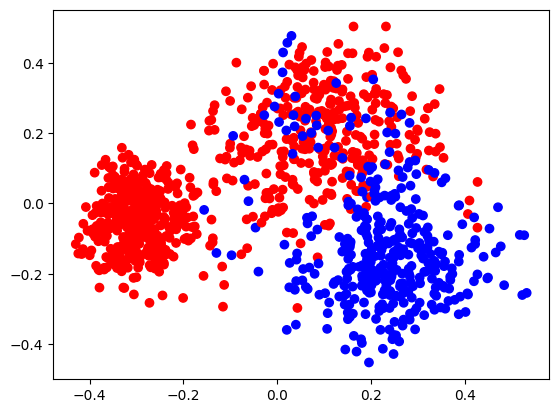

In [16]:
plt.scatter(x = projected[:, 0], y=projected[:,1], color=colors)
plt.show()

## Generation-augmented Retrieval (GAR)

* Generation-augmented retrieval expands the user's query using an LLM.
* Retrieval compares against the embedding of the generated query
* Here, we do **code completion** to obtain an example code from **natural language**, which should make it **easier to match against other code** because they now share the same qualities.

In [17]:
from transformers import GemmaTokenizer, AutoModelForCausalLM
gen_model_id = "google/codegemma-1.1-2b"
gen_tokenizer = GemmaTokenizer.from_pretrained(gen_model_id)
gen_model = AutoModelForCausalLM.from_pretrained(gen_model_id, device_map=gpu, torch_dtype=torch.bfloat16)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu_pytorch_tanh`, edit the `model.config` to set `hidden_activation=gelu_pytorch_tanh`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
# A standard greedy generation helper
def generate(prompt, max_new_tokens=128):
    inputs = gen_tokenizer.encode(prompt, return_tensors='pt').to(gpu)
    outputs = gen_model.generate(inputs, max_new_tokens=max_new_tokens)
    return gen_tokenizer.decode(outputs[0])

def generate_retrieve(embeddings, prompt):
    generated = generate(prompt)
    return retrieve(embeddings, generated), generated

In [19]:
top_10, generated = generate_retrieve(embeddings, "# A flask test case to verify user login functionality:\n")[:10]

print('Generated query:')
print(generated)

print_retrieval_results(top_10)

Generated query:
<bos># A flask test case to verify user login functionality:
from flask import Flask, request, jsonify
import requests

app = Flask(__name__)

# Define the API endpoint
api_url = "http://localhost:5000/api/login"

# Test case 1: Valid login
@app.route("/api/login", methods=["POST"])
def test_valid_login():
    # Define the test data
    test_data = {
        "username": "testuser",
        "password": "testpassword"
    }

    # Send a POST request to the API endpoint
    response = requests.post(
1: ./flask.git:test_auth.py:test_login (0.67)
--------------------------------------------------------------------------------
def test_login(client, auth):
    # test that viewing the page renders without template errors
    assert client.get("/auth/login").status_code == 200

    # test that successful login redirects to the index page
    response = auth.login()
    assert response.headers["Location"] == "/"

    # login request set the user_id in the session
    # check t